## Problem Overview
Calculate **location entropy per user (taxi driver)** from the EPFL Cabspotting GPS dataset.

### Shannon Entropy Formula
$$E = -\sum_{i} p(i) \times \log_2(p(i))$$

Where $p(i)$ is the probability of the user being at location $i$.

### Dataset
- **Source**: EPFL Cabspotting - San Francisco Taxi GPS Traces
- **Format**: Each line = `[latitude, longitude, occupancy, timestamp]`
- **Size**: 536 taxi drivers, ~11M GPS records

---

## 1. Import Dependencies

In [26]:
import numpy as np
import pandas as pd
from typing import Union, List, Tuple, Optional
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import os
import plotly.express as px
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

# Configure visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully")

Libraries loaded successfully


## 2.  Entropy Functions

In [27]:
def calculate_location_entropy(
    locations: Union[List, np.ndarray, pd.Series],
    base: int = 2,
    normalize: bool = False
) -> float:
    
    # Input validation
    if locations is None or len(locations) == 0:
        return 0.0
    
    # Convert to numpy array for efficient processing
    if isinstance(locations, pd.Series):
        locations = locations.dropna().values
    else:
        locations = np.array(locations)
    
    # Filter out None/NaN values
    locations = locations[pd.notna(locations)]
    
    # Edge case: empty after filtering
    if len(locations) == 0:
        return 0.0
    
    # Edge case: single location (no uncertainty)
    if len(np.unique(locations)) == 1:
        return 0.0
    
    # Calculate probabilities
    unique, counts = np.unique(locations, return_counts=True)
    probabilities = counts / len(locations)
    
    # Calculate entropy with numerical stability
    epsilon = 1e-10
    probabilities = np.clip(probabilities, epsilon, 1.0)
    
    if base == 2:
        entropy = -np.sum(probabilities * np.log2(probabilities))
    elif base == np.e:
        entropy = -np.sum(probabilities * np.log(probabilities))
    else:
        entropy = -np.sum(probabilities * np.log(probabilities) / np.log(base))
    
    # Normalize if requested
    if normalize and len(unique) > 1:
        max_entropy = np.log2(len(unique)) if base == 2 else np.log(len(unique)) / np.log(base)
        entropy = entropy / max_entropy
    
    return float(entropy)


# Test the function
print("Testing entropy function:")
print(f"  ['A', 'A', 'B', 'B'] -> {calculate_location_entropy(['A', 'A', 'B', 'B']):.3f} bits (expected: 1.0)")
print(f"  ['A', 'A', 'A'] -> {calculate_location_entropy(['A', 'A', 'A']):.3f} bits (expected: 0.0)")
print(f"  ['A', 'B', 'C', 'D'] -> {calculate_location_entropy(['A', 'B', 'C', 'D']):.3f} bits (expected: 2.0)")

Testing entropy function:
  ['A', 'A', 'B', 'B'] -> 1.000 bits (expected: 1.0)
  ['A', 'A', 'A'] -> 0.000 bits (expected: 0.0)
  ['A', 'B', 'C', 'D'] -> 2.000 bits (expected: 2.0)


In [28]:
def discretize_coordinates(
    lat: float, 
    lon: float, 
    precision: float = 0.001
) -> str:
    """
    Discretize GPS coordinates into grid cells.
    
    Parameters
    ----------
    lat : float
        Latitude in decimal degrees
    lon : float
        Longitude in decimal degrees
    precision : float, default=0.001
        Grid cell size in degrees (~111m for lat, ~85m for lon at SF latitude)
    
    Returns
    -------
    str
        Location identifier string "lat_lon"
    """
    lat_bin = round(lat / precision) * precision
    lon_bin = round(lon / precision) * precision
    return f"{lat_bin:.3f}_{lon_bin:.3f}"


def calculate_entropy_per_user(
    df: pd.DataFrame,
    user_col: str = 'user_id',
    location_col: str = 'location_id',
    base: int = 2,
    normalize: bool = False,
    include_stats: bool = True
) -> pd.DataFrame:
    """
    Calculate location entropy for each user in a dataset.
    
    Production-ready batch processing function.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Spatio-temporal dataset with user and location columns
    user_col : str, default='user_id'
        Column name for user identifiers
    location_col : str, default='location_id'
        Column name for location identifiers
    base : int, default=2
        Logarithm base for entropy calculation
    normalize : bool, default=False
        If True, normalize entropy values
    include_stats : bool, default=True
        If True, include additional statistics per user
    
    Returns
    -------
    pandas.DataFrame
        DataFrame with user_id and entropy, plus optional statistics
    """
    # Validate inputs
    if user_col not in df.columns:
        raise ValueError(f"Column '{user_col}' not found in DataFrame")
    if location_col not in df.columns:
        raise ValueError(f"Column '{location_col}' not found in DataFrame")
    
    # Calculate entropy per user
    result = df.groupby(user_col)[location_col].agg([
        ('entropy', lambda x: calculate_location_entropy(x, base=base, normalize=normalize)),
    ])
    
    if include_stats:
        stats_df = df.groupby(user_col)[location_col].agg([
            ('total_records', 'count'),
            ('unique_locations', 'nunique'),
            ('most_frequent_location', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
        ])
        result = result.join(stats_df)
        result['location_diversity'] = result['unique_locations'] / result['total_records']
    
    result = result.reset_index()
    return result


print("Helper functions defined")

Helper functions defined


## 3. Load Cabspotting Dataset

In [29]:
def load_cab_trace(filepath: Path) -> pd.DataFrame:
    """
    Load a single cab trace file.
    """
    try:
        df = pd.read_csv(
            filepath,
            sep=' ',
            header=None,
            names=['lat', 'lon', 'occupancy', 'timestamp']
        )
        return df
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return pd.DataFrame()


def load_all_cabs(data_dir: str, max_cabs: Optional[int] = None) -> pd.DataFrame:
    """
    Load all cab trace files from the cabspotting dataset.
    """
    data_path = Path(data_dir)
    trace_files = list(data_path.glob("new_*.txt"))
    
    if max_cabs:
        trace_files = trace_files[:max_cabs]
    
    print(f"Loading {len(trace_files)} cab trace files...")
    
    all_data = []
    for i, filepath in enumerate(trace_files):
        cab_id = filepath.stem.replace('new_', '')
        df = load_cab_trace(filepath)
        
        if not df.empty:
            df['cab_id'] = cab_id
            all_data.append(df)
        
        if (i + 1) % 100 == 0:
            print(f"  Loaded {i + 1}/{len(trace_files)} files...")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal records loaded: {len(combined_df):,}")
    
    return combined_df

In [30]:
# Configuration
DATA_DIR = r"cabspottingdata"

# Load all cab data
raw_df = load_all_cabs(DATA_DIR)

# Display sample
print(f"\nDataset shape: {raw_df.shape}")
print(f"Number of unique cabs: {raw_df['cab_id'].nunique()}")
print(f"\nSample data:")
raw_df.head(10)

Loading 536 cab trace files...
  Loaded 100/536 files...
  Loaded 200/536 files...
  Loaded 300/536 files...
  Loaded 400/536 files...
  Loaded 500/536 files...

Total records loaded: 11,219,955

Dataset shape: (11219955, 5)
Number of unique cabs: 536

Sample data:


,lat,lon,occupancy,timestamp,cab_id
0,37.75134,-122.39488,0,1213084687,abboip
1,37.75136,-122.39527,0,1213084659,abboip
2,37.75199,-122.39460,0,1213084540,abboip
3,37.75080,-122.39346,0,1213084489,abboip
4,37.75015,-122.39256,0,1213084237,abboip
5,37.75454,-122.39227,0,1213084177,abboip
6,37.75901,-122.39250,0,1213084172,abboip
7,37.77053,-122.39788,0,1213084092,abboip
8,37.77669,-122.39382,0,1213084032,abboip
9,37.78194,-122.38844,0,1213083971,abboip


## 4. Data Preprocessing

In [31]:
# Grid precision: 0.001 degrees ≈ 111 meters
GRID_PRECISION = 0.001

# Discretize GPS coordinates into location cells
print("Discretizing GPS coordinates into grid cells...")
raw_df['location_id'] = raw_df.apply(
    lambda row: discretize_coordinates(row['lat'], row['lon'], GRID_PRECISION),
    axis=1
)

# Convert timestamp to datetime
raw_df['datetime'] = pd.to_datetime(raw_df['timestamp'], unit='s')

print(f"Created {raw_df['location_id'].nunique():,} unique location cells")
print(f"\nSample preprocessed data:")
raw_df[['cab_id', 'lat', 'lon', 'location_id', 'datetime']].head(10)

Discretizing GPS coordinates into grid cells...
Created 44,775 unique location cells

Sample preprocessed data:


,cab_id,lat,lon,location_id,datetime
0,abboip,37.75134,-122.39488,37.751_-122.395,2008-06-10 07:58:07
1,abboip,37.75136,-122.39527,37.751_-122.395,2008-06-10 07:57:39
2,abboip,37.75199,-122.39460,37.752_-122.395,2008-06-10 07:55:40
3,abboip,37.75080,-122.39346,37.751_-122.393,2008-06-10 07:54:49
4,abboip,37.75015,-122.39256,37.750_-122.393,2008-06-10 07:50:37
5,abboip,37.75454,-122.39227,37.755_-122.392,2008-06-10 07:49:37
6,abboip,37.75901,-122.39250,37.759_-122.392,2008-06-10 07:49:32
7,abboip,37.77053,-122.39788,37.771_-122.398,2008-06-10 07:48:12
8,abboip,37.77669,-122.39382,37.777_-122.394,2008-06-10 07:47:12
9,abboip,37.78194,-122.38844,37.782_-122.388,2008-06-10 07:46:11


## 5. Calculate Location Entropy Per Cab

In [32]:
# Calculate entropy for each cab
entropy_df = calculate_entropy_per_user(
    raw_df,
    user_col='cab_id',
    location_col='location_id',
    base=2,
    include_stats=True
)

print(f"Calculated entropy for {len(entropy_df)} cabs")
print(f"\nSummary Statistics")
print(entropy_df[['entropy', 'total_records', 'unique_locations']].describe().round(2))

Calculated entropy for 536 cabs

Summary Statistics
       entropy  total_records  unique_locations
count   536.00         536.00            536.00
mean     10.49       20932.75           3849.43
std       0.93        6204.00            806.39
min       0.78          59.00              2.00
25%      10.44       18721.25           3664.75
50%      10.70       22813.50           4004.00
75%      10.86       25037.75           4310.00
max      11.40       49367.00           5874.00


In [33]:
# Display top 10 results
entropy_df.sort_values('entropy', ascending=False).head(10)

,cab_id,entropy,total_records,unique_locations,most_frequent_location,location_diversity
276,idlorra,11.397595,21773,5068,37.752_-122.395,0.232765
327,iorjtwav,11.293310,25669,5065,37.751_-122.395,0.197320
114,eapceou,11.289440,27539,4982,37.782_-122.450,0.180907
126,ecforj,11.280619,22110,4692,37.751_-122.395,0.212212
19,adnerst,11.271781,25261,5173,37.752_-122.395,0.204782
517,urfhod,11.246769,23502,4951,37.643_-122.427,0.210663
516,upthin,11.235336,49367,5874,37.752_-122.394,0.118986
353,ivheoo,11.234817,23890,4684,37.688_-122.479,0.196065
21,aducrisi,11.232561,21886,4996,37.616_-122.386,0.228274
268,icwiroic,11.231556,26067,4409,37.868_-122.297,0.169141


## 6. Exploratory Data Analysis

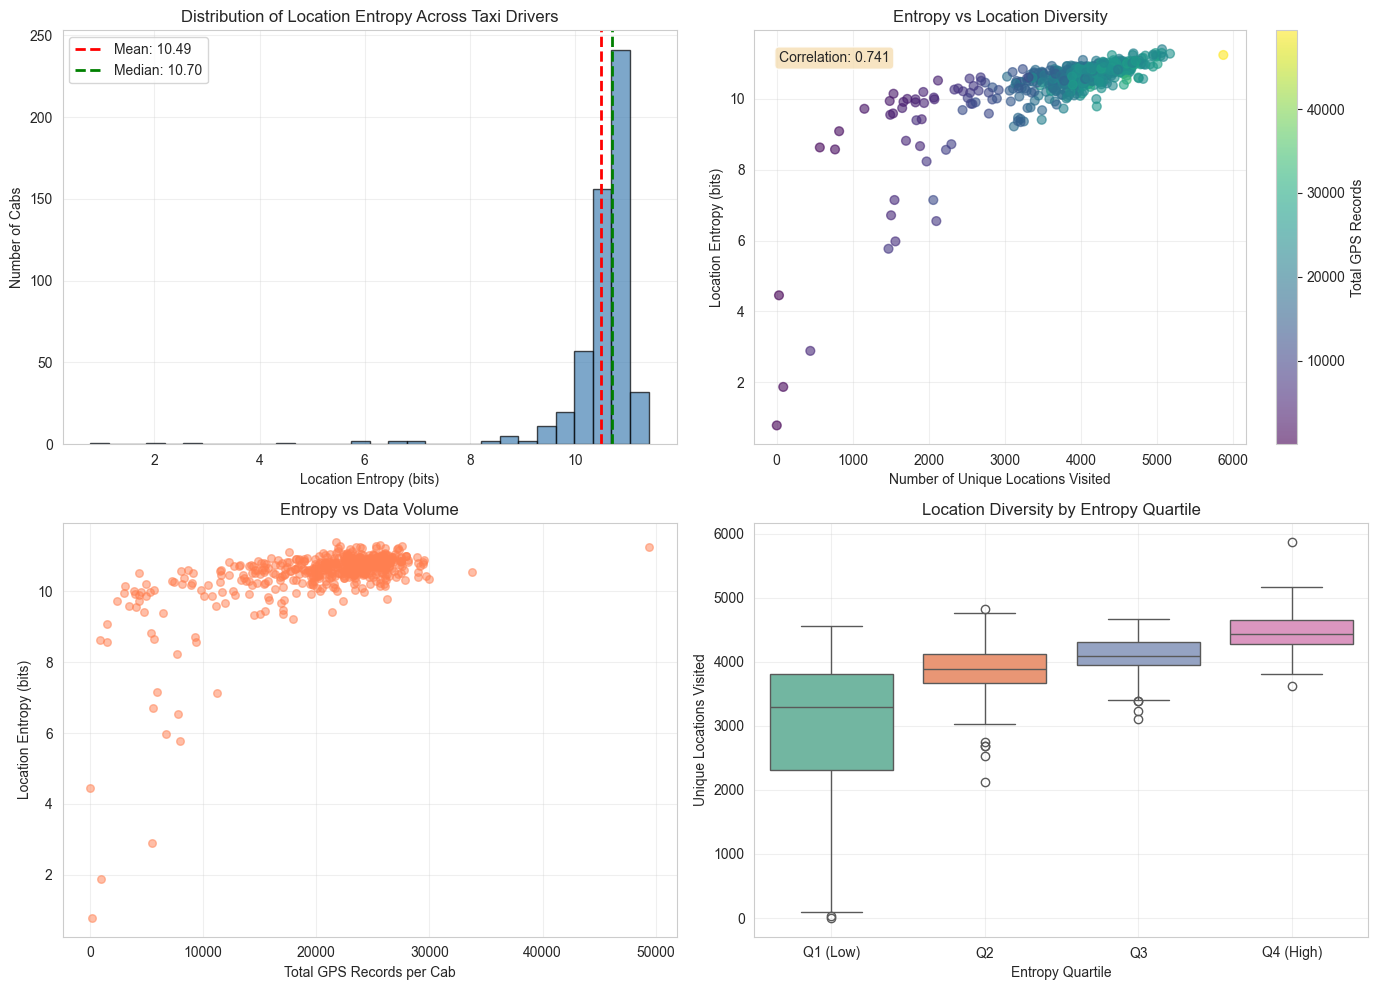

Saved visualization to entropy_analysis.png


In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Entropy distribution histogram
axes[0, 0].hist(entropy_df['entropy'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
mean_e = entropy_df['entropy'].mean()
median_e = entropy_df['entropy'].median()
axes[0, 0].axvline(mean_e, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_e:.2f}')
axes[0, 0].axvline(median_e, color='green', linestyle='--', linewidth=2, label=f'Median: {median_e:.2f}')
axes[0, 0].set_xlabel('Location Entropy (bits)')
axes[0, 0].set_ylabel('Number of Cabs')
axes[0, 0].set_title('Distribution of Location Entropy Across Taxi Drivers')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Entropy vs Unique Locations
scatter = axes[0, 1].scatter(
    entropy_df['unique_locations'], 
    entropy_df['entropy'],
    alpha=0.6, s=40, c=entropy_df['total_records'], cmap='viridis'
)
axes[0, 1].set_xlabel('Number of Unique Locations Visited')
axes[0, 1].set_ylabel('Location Entropy (bits)')
axes[0, 1].set_title('Entropy vs Location Diversity')
plt.colorbar(scatter, ax=axes[0, 1], label='Total GPS Records')
corr = entropy_df[['entropy', 'unique_locations']].corr().iloc[0, 1]
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}',
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axes[0, 1].grid(alpha=0.3)

# 3. Entropy vs Total Records
axes[1, 0].scatter(entropy_df['total_records'], entropy_df['entropy'], alpha=0.5, s=30, color='coral')
axes[1, 0].set_xlabel('Total GPS Records per Cab')
axes[1, 0].set_ylabel('Location Entropy (bits)')
axes[1, 0].set_title('Entropy vs Data Volume')
axes[1, 0].grid(alpha=0.3)

# 4. Box plot by entropy quartiles
entropy_df['entropy_quartile'] = pd.qcut(entropy_df['entropy'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
sns.boxplot(data=entropy_df, x='entropy_quartile', y='unique_locations', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_xlabel('Entropy Quartile')
axes[1, 1].set_ylabel('Unique Locations Visited')
axes[1, 1].set_title('Location Diversity by Entropy Quartile')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('entropy_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved visualization to entropy_analysis.png")

## 7. User Segmentation by Mobility Patterns

USER SEGMENTATION BY MOBILITY PATTERNS
                          Count  Entropy Mean  Entropy Std  Avg Locations  \
segment                                                                     
Low Mobility (Routine)      179          9.84         1.38        3184.36   
Medium Mobility             178         10.68         0.08        3986.60   
High Mobility (Explorer)    179         10.95         0.12        4378.10   

                          Avg Records  
segment                                
Low Mobility (Routine)       16646.31  
Medium Mobility              22045.80  
High Mobility (Explorer)     24112.36  


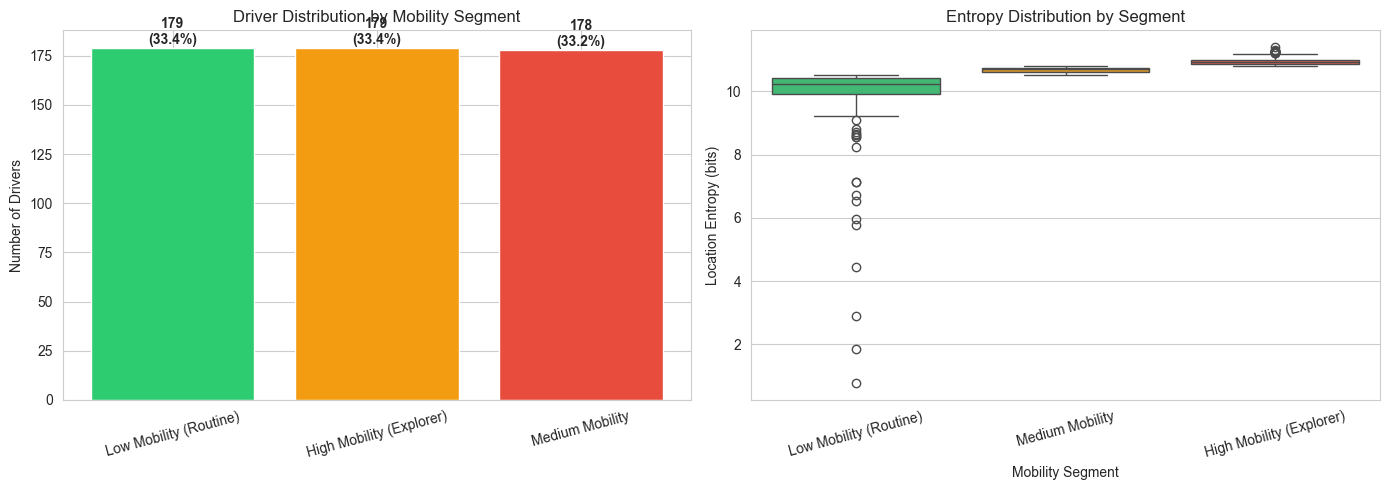

In [35]:
# Segment drivers into 3 groups based on entropy
labels = ['Low Mobility (Routine)', 'Medium Mobility', 'High Mobility (Explorer)']
entropy_df['segment'] = pd.qcut(entropy_df['entropy'], q=3, labels=labels, duplicates='drop')

# Analyze segments
segment_summary = entropy_df.groupby('segment').agg({
    'cab_id': 'count',
    'entropy': ['mean', 'std'],
    'unique_locations': 'mean',
    'total_records': 'mean'
}).round(2)
segment_summary.columns = ['Count', 'Entropy Mean', 'Entropy Std', 'Avg Locations', 'Avg Records']


print("USER SEGMENTATION BY MOBILITY PATTERNS")

print(segment_summary)

# Visualize segments
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segment distribution
segment_counts = entropy_df['segment'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0].bar(range(len(segment_counts)), segment_counts.values, color=colors)
axes[0].set_xticks(range(len(segment_counts)))
axes[0].set_xticklabels(segment_counts.index, rotation=15)
axes[0].set_ylabel('Number of Drivers')
axes[0].set_title('Driver Distribution by Mobility Segment')
for i, v in enumerate(segment_counts.values):
    axes[0].text(i, v + 2, f"{v}\n({v/len(entropy_df)*100:.1f}%)", ha='center', fontweight='bold')

# Box plot of entropy by segment
sns.boxplot(data=entropy_df, x='segment', y='entropy', ax=axes[1], palette=colors)
axes[1].set_xlabel('Mobility Segment')
axes[1].set_ylabel('Location Entropy (bits)')
axes[1].set_title('Entropy Distribution by Segment')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

In [36]:
entropy_viz = pd.read_csv('entropy_results.csv')
entropy_viz[['freq_lat', 'freq_lon']] = entropy_viz['most_frequent_location'].str.split('_', expand=True).astype(float)

segment_colors = {
    'Low Mobility (Routine)': '#2ecc71',
    'Medium Mobility': '#f39c12', 
    'High Mobility (Explorer)': '#e74c3c'
}


In [37]:
fig1 = px.scatter_3d(
    entropy_viz,
    x='total_records',
    y='unique_locations', 
    z='entropy',
    color='segment',
    color_discrete_map=segment_colors,
    size='location_diversity',
    size_max=20,
    hover_name='cab_id',
    hover_data={
        'entropy': ':.2f',
        'total_records': ':,',
        'unique_locations': ':,',
        'location_diversity': ':.3f',
        'segment': True
    },
    title='3D Taxi Driver Mobility Landscape',
    labels={
        'total_records': 'GPS Records',
        'unique_locations': 'Unique Locations',
        'entropy': 'Location Entropy (bits)',
        'segment': 'Mobility Segment'
    }
)

fig1.update_layout(
    scene=dict(
        xaxis_title='Total GPS Records',
        yaxis_title='Unique Locations Visited',
        zaxis_title='Location Entropy (bits)',
        bgcolor='rgba(20,20,30,0.95)',
        xaxis=dict(backgroundcolor='rgba(20,20,30,0.8)', gridcolor='rgba(100,100,120,0.3)'),
        yaxis=dict(backgroundcolor='rgba(20,20,30,0.8)', gridcolor='rgba(100,100,120,0.3)'),
        zaxis=dict(backgroundcolor='rgba(20,20,30,0.8)', gridcolor='rgba(100,100,120,0.3)'),
    ),
    paper_bgcolor='rgba(15,15,25,1)',
    plot_bgcolor='rgba(15,15,25,1)',
    font=dict(color='white', family='Arial'),
    legend=dict(
        bgcolor='rgba(30,30,40,0.9)',
        bordercolor='rgba(100,100,120,0.5)',
        borderwidth=1
    ),
    margin=dict(l=0, r=0, t=50, b=0),
    height=700
)

fig1.show()


## 8. Key Insights from Location Entropy Analysis

In [38]:
print("KEY INSIGHTS FROM LOCATION ENTROPY ANALYSIS")

# Summary statistics
print("\nSUMMARY STATISTICS:")
print(f"- Total taxi drivers analyzed: {len(entropy_df)}")
print(f"- Mean entropy: {entropy_df['entropy'].mean():.3f} bits")
print(f"- Median entropy: {entropy_df['entropy'].median():.3f} bits")
print(f"- Std deviation: {entropy_df['entropy'].std():.3f} bits")
print(f"- Min entropy: {entropy_df['entropy'].min():.3f} bits")
print(f"- Max entropy: {entropy_df['entropy'].max():.3f} bits")

# Interpretation
mean_e = entropy_df['entropy'].mean()
equiv_locations = 2 ** mean_e
print(f"\nINTERPRETATION:")
print(f"- Average entropy of {mean_e:.2f} bits suggests drivers typically")
print(f"- distribute their time across ~{equiv_locations:.0f} equally-visited locations")

# Top/Bottom drivers
print("\n MOST ROUTINE DRIVERS (Lowest Entropy):")
lowest = entropy_df.nsmallest(5, 'entropy')[['cab_id', 'entropy', 'unique_locations', 'total_records']]
print(lowest.to_string(index=False))

print("\n MOST EXPLORATORY DRIVERS (Highest Entropy):")
highest = entropy_df.nlargest(5, 'entropy')[['cab_id', 'entropy', 'unique_locations', 'total_records']]
print(highest.to_string(index=False))

# Correlations
print("\n CORRELATIONS:")
corr_locs = entropy_df[['entropy', 'unique_locations']].corr().iloc[0, 1]
corr_records = entropy_df[['entropy', 'total_records']].corr().iloc[0, 1]
print(f"- Entropy vs Unique Locations: {corr_locs:.3f} (strong positive)")
print(f"- Entropy vs Total Records: {corr_records:.3f}")

print("\n" + "=" * 80)

KEY INSIGHTS FROM LOCATION ENTROPY ANALYSIS

SUMMARY STATISTICS:
- Total taxi drivers analyzed: 536
- Mean entropy: 10.491 bits
- Median entropy: 10.698 bits
- Std deviation: 0.929 bits
- Min entropy: 0.782 bits
- Max entropy: 11.398 bits

INTERPRETATION:
- Average entropy of 10.49 bits suggests drivers typically
- distribute their time across ~1439 equally-visited locations

 MOST ROUTINE DRIVERS (Lowest Entropy):
  cab_id  entropy  unique_locations  total_records
egoiwroi 0.782228                 2            185
 ifeshce 1.868349                87           1003
  abcoij 2.885279               443           5454
  eotcue 4.453517                31             59
  elvgid 5.766672              1471           8004

 MOST EXPLORATORY DRIVERS (Highest Entropy):
  cab_id   entropy  unique_locations  total_records
 idlorra 11.397595              5068          21773
iorjtwav 11.293310              5065          25669
 eapceou 11.289440              4982          27539
  ecforj 11.280619   

## 9. Product Ideas Derived from Location Entropy Insights

## Product Ideas Derived from Location Entropy Analysis

#### Based on SDG 11: Sustainable Cities and Communities
1. **Congestion Reduction Intelligence**
Analyze collective driver entropy to predict traffic congestion hotspots 30-60 minutes in advance. Share insights with traffic management systems.
Implementation: Neural networks processing entropy time-series + real-time API integration with smart city traffic systems.
Impact: 15-25% reduction in urban congestion during peak hours, reducing emissions.

2. **Green Zone Prioritization**
Low-entropy drivers in high-pollution zones and incentivizes them to switch to EVs first (since predictable routes = easier charging planning).
Implementation: Computer vision + entropy scoring to match EV charging station locations with driver patterns.
Impact: Accelerate EV adoption in pollution hotspots, reducing local emissions by 20-30%.

---

3. **Battery & GPS Optimization**  
   For routine drivers with low entropy, GPS polling frequency can be reduced to save battery and bandwidth since their next location is highly predictable.  
   _Implementation:_ Use adaptive sampling based on real-time entropy scores.  
   _Impact:_ 20-30% reduction in GPS-related battery consumption.

---


## 10. Export Results

In [39]:
# Save entropy results to CSV
output_file = 'entropy_results.csv'
entropy_df.to_csv(output_file, index=False)
print(f"Saved results to {output_file}")

# Display final summary
print(f"\nANALYSIS")
print(f"- Analyzed {len(entropy_df)} taxi drivers")
print(f"- Processed {len(raw_df):,} GPS records")
print(f"- Created {raw_df['location_id'].nunique():,} unique location cells")
print(f"- Saved visualizations to entropy_analysis.png")
print(f"- Saved results to {output_file}")

Saved results to entropy_results.csv

ANALYSIS
- Analyzed 536 taxi drivers
- Processed 11,219,955 GPS records
- Created 44,775 unique location cells
- Saved visualizations to entropy_analysis.png
- Saved results to entropy_results.csv


---

### Key Findings:
- Taxi drivers show diverse mobility patterns with entropy ranging from low (routine) to high (exploratory)
- Strong correlation between entropy and unique locations visited
- Three distinct driver segments identified for targeted strategies

